# Super-decimated readout

There are two ways to do time-series readouts with durations that exceed the decimated buffer capacity: the DDR4 buffer and the "super-decimated readout" technique.

The DDR4 buffer is relatively simple to use (see https://github.com/openquantumhardware/qick/blob/main/qick_demos/08_Special_buffers.ipynb) and has the same time resolution as the decimated buffer, but can only be triggered once in a program (so if you want multiple shots, you need to record them all in a single DDR4 capture and slice the data later), can only be connected to one readout channel in a program, and for very long readouts the data volume may limit the rep rate.

Super-decimated readout uses repeated accumulated readouts to emulate a decimated readout.
The time resolution is reduced to the interval between accumulated readouts.
Super-decimated readout is not so much a QICK feature, as a hacky way to adapt QICK features to do something they were not intended to do.
As such, it requires a high level of understanding of QICK; don't attempt unless you are already comfortable with writing your own QICK programs.

In [1]:
# boilerplate code for jupyter setup
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import the QICK drivers and auxiliary libraries
from qick import *
# from qick.averager_program import QickSweep

In [2]:
# Load bitstream
soc = QickSoc()
soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.356

Firmware configuration (built Wed Sep  6 18:49:29 2023):

	Global clocks (MHz): tProc dispatcher timing 409.600, RF reference 491.520
	Groups of related clocks: [tProc clock, DAC tile 0], [DAC tile 2], [ADC tile 0]

	2 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9830.400 Msps, fabric=614.400 MHz
		envelope memory: 65536 complex samples (6.667 us)
		32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - fs=9830.400 Msps, fabric=614.400 MHz
		envelope memory: 65536 complex samples (6.667 us)
		32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 Msps, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		axis_avg_buffer v1.0 (no edge counter, no weights)
		memory 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 0 is ADC_D
	1:	axis_readout_v

In [3]:
GEN_CH = 0
RO_CH = 0
FREQ = 250 # MHz
DDR4_OFFSET = 0.02 # us


We're demonstrating two useful techniques in this program:
* We're using a periodic pulse to play a constant-envelope pulse of unlimited length.

 Normally you play pulses in a single step by telling the generator to play a pulse with a defined length; this length is typically limited to a 16-bit integer.

 Here we are using a two-step process, where first we tell the generator to play a short pulse repeatedly (back-to-back, with no gaps - so this will look like a continuous tone), and later we tell it to play a "stopper" pulse (a zero-gain pulse, which stops the repetition without playing any visible signal itself).
These pulses should usually be as short as possible: you can't interrupt a pulse while it's playing, so after the stopper is sent the periodic pulse is still going to play to completion.

* We're using super-decimated readout. 

 We need to send a series of readout triggers with a fixed spacing: we do this by writing a for loop in the QICK assembly language. The AveragerProgram is built around a similar for loop, which you can see in https://docs.qick.dev/latest/_modules/qick/averager_program.html#AveragerProgram.make_program.

 In order for the data-processing code to grab the data we captured, it needs to know how many triggers we send in a shot. Normally it figures this out by counting `trigger()` statements in the body, but in our program we have one trigger statement that gets looped over. So we need to use `set_reads_per_shot()` to explicity declare the number of triggers.
 
 
We're doing some other stuff for testing/visualization purposes:

* We're setting separate generator and readout frequencies; if we set them to different values, our downconverted signal will have a slow oscillation which will show up in our super-decimated data points.
* We're also triggering the DDR4 buffer, so we can align our super-decimated data points with a global timeline.

In [4]:
class LongPulseProgram(AveragerProgram):
    def __init__(self, soccfg, cfg):
        super().__init__(soccfg, cfg)
        # tell the data-processing code how many times we're triggering the readout
        self.set_reads_per_shot([config['n_trigs']])
    
    def initialize(self):
        cfg=self.cfg

        # set the nyquist zone
        self.declare_gen(ch=cfg['gen_ch'], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        self.declare_readout(ch=cfg['ro_ch'], length=cfg['ro_len'],
                             freq=self.cfg['ro_freq'], gen_ch=cfg['gen_ch'])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"], gen_ch=cfg['gen_ch'], ro_ch=cfg['ro_ch'])
        
        # we'll be setting up two types of pulses: the periodic pulse and the stopper pulse
        # for efficiency, the parameters that the two pulses have in common should be set in initialize()
        self.default_pulse_registers(ch=cfg['gen_ch'], style='const', freq=freq, phase=0,
                                     length=3, # this is the minimum length for a pulse
                                    )
        self.synci(200)  # give processor some time to configure pulses
        
    def body(self):
        cfg=self.cfg

        # set up and play the periodic pulse
        self.set_pulse_registers(ch=cfg['gen_ch'], 
                                 gain=cfg['pulse_gain'], 
                                 mode='periodic')
        self.pulse(ch=cfg['gen_ch'], t=0)
        # set up and play the dummy "stopper" pulse
        self.set_pulse_registers(ch=cfg['gen_ch'], 
                                 gain=0,
                                 mode='oneshot')
        self.pulse(ch=cfg['gen_ch'], t=cfg['pulse_len'])
        
        # this block of code is how you write a for loop
        COUNTER_PAGE, COUNTER_ADDR = (0, 1) # the counter value goes in a register
        self.safe_regwi(COUNTER_PAGE, COUNTER_ADDR, cfg['n_trigs']-1) # pseudocode: "i = n_trigs - 1"
        self.label("TRIGLOOP") # pseudocode: "do"
        
        self.trigger(adcs=[cfg['ro_ch']], # trigger the standard buffer
                     ddr4=True, # trigger the DDR4 (only the first DDR4 trigger will be used)
                     pins=[0],  # if you put a scope on output pin 0, you will see a pulse for each trigger
                     adc_trig_offset=cfg['adc_trig_offset'])
        self.synci(cfg['trig_interval']) # push the reference time forward for the next loop iteration
        
        self.loopnz(COUNTER_PAGE, COUNTER_ADDR, 'TRIGLOOP') # pseudocode: "while (i-- != 0)"
        
        self.waiti(0, 0) # the first arg is a fummy value, the second is the time until which to wait
        self.synci(self.us2cycles(cfg['relax_delay'])) # push the reference time forward for the next shot

First we'll run in decimated mode, where we'll capture a time window for each of our triggers.
In this mode, the total length of our decimated windows has to fit in the decimated buffer.
Later we'll switch to accumulated mode, where we only get the average of each window and can run for much longer.

In [5]:
config={"gen_ch":GEN_CH, # --Fixed
        "ro_ch":RO_CH, # --Fixed
        
        "pulse_len": soccfg.us2cycles(1.0), # [us]
        "ro_len": soccfg.us2cycles(0.1, ro_ch=RO_CH), # [us]
        "trig_interval": soccfg.us2cycles(0.15), # [us]

        "pulse_gain":30000, # [DAC units, +/- 2^15-2]
        "pulse_freq": FREQ, # [MHz]
        "ro_freq": FREQ+0.5, # [MHz]

        "adc_trig_offset": 100, # [tProc clock ticks]
        
        "n_trigs": 10,

        "relax_delay":1.0, # [us]

        "reps":1, # --Fixed
        "soft_avgs":1
       }

prog =LongPulseProgram(soccfg, config)

n_transfers = 1000 # each transfer (aka burst) is 256 decimated samples

# Arm the DDR4 buffer
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

# Run the program
iq_list = prog.acquire_decimated(soc, progress=True)
# print(prog)

  0%|          | 0/1 [00:00<?, ?it/s]

We can plot the decimated data on top of the DDR4 data, to see that we're triggering the standard buffer at the expected times.

Two caveats:
* The DDR4 and standard buffers have slightly different trigger delays, so we shift the plots by a DDR4_OFFSET value to line them up. This value is firmware-dependent. Another way to align the data would be to trigger the DDR4 buffer slightly earlier.
* If you look very closely, you will probably find that the individual segments from the standard buffer are not completely consistently aligned with the DDR4 - there will be a jitter of one clock tick. This happens when the tProc and readout clocks have different frequencies; the triggers are scheduled in tProc time units and get translated to the readout clock (jargon: "clock domain crossing").

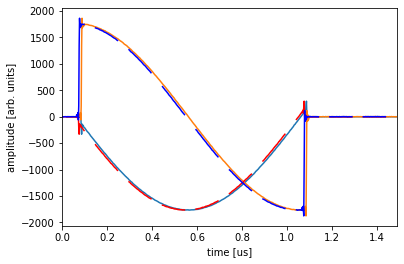

In [6]:
trig_interval = soccfg.cycles2us(config['trig_interval'])

# could work out how many DDR4 transfers we need . . .
# nsamp_ro = trig_interval*config['n_trigs']*soccfg['readouts'][RO_CH]['f_output']
# nt = np.ceil((soccfg['ddr4_buf']['junk_len'] + nsamp_ro)/soccfg['ddr4_buf']['burst_len'])

iq_ddr4 = soc.get_ddr4(n_transfers)
t_ddr4 = prog.get_time_axis_ddr4(RO_CH, iq_ddr4) + DDR4_OFFSET
plt.plot(t_ddr4, iq_ddr4[:,0], label="I")
plt.plot(t_ddr4, iq_ddr4[:,1], label="Q")

# get the time window for the decimated data, and the interval between triggers
t_dec = prog.get_time_axis(0)
for i, iq in enumerate(iq_list[0]):
    plt.plot(t_dec + i*trig_interval, iq[0], label="I value", color='red')
    plt.plot(t_dec + i*trig_interval, iq[1], label="Q value", color='blue')

plt.xlim([0, trig_interval*config['n_trigs']])
plt.ylabel("amplitude [arb. units]")
plt.xlabel("time [us]");


Now let's run the same program in accumulated mode.
We get 10 points instead of 10 time slices.

  0%|          | 0/1 [00:00<?, ?it/s]

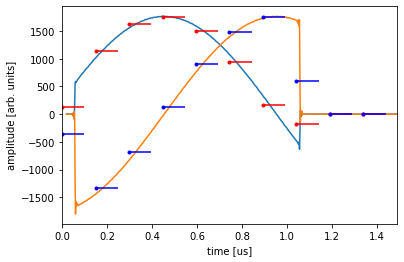

In [7]:
n_transfers = 1000 # each transfer (aka burst) is 256 decimated samples

# Arm the DDR4 buffer
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

# Run the program
iq_list = prog.acquire(soc, progress=True)

iq_ddr4 = soc.get_ddr4(n_transfers)
t_ddr4 = prog.get_time_axis_ddr4(RO_CH, iq_ddr4) + DDR4_OFFSET
plt.plot(t_ddr4, iq_ddr4[:,0], label="I")
plt.plot(t_ddr4, iq_ddr4[:,1], label="Q")

trig_interval = soccfg.cycles2us(config['trig_interval'])
t_superdec = trig_interval*(np.arange(config['n_trigs']))

# we'll plot a point at the trigger time, and a bar to indicate the integration window
bars = np.zeros((2,config['n_trigs']))
bars[1,:] = soccfg.cycles2us(config['ro_len'], ro_ch=RO_CH)

plt.errorbar(t_superdec, iq_list[0][0], xerr=bars, fmt='.', label="I value", color='red')
plt.errorbar(t_superdec, iq_list[1][0], xerr=bars, fmt='.', label="Q value", color='blue')

plt.xlim([0, trig_interval*config['n_trigs']])
plt.ylabel("amplitude [arb. units]")
plt.xlabel("time [us]");


Now let's do a much longer acquisition.

  0%|          | 0/1 [00:00<?, ?it/s]

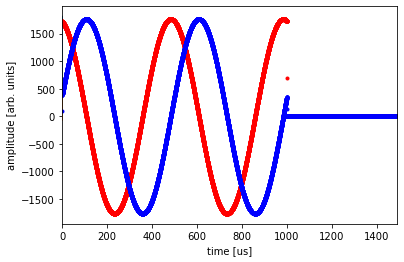

In [9]:
config["pulse_len"] = soccfg.us2cycles(1000.0)
config["n_trigs"] = 10000
config["ro_freq"] = FREQ+0.002, # [MHz]

prog =LongPulseProgram(soccfg, config)

# Arm the DDR4 buffer
soc.arm_ddr4(ch=RO_CH, nt=n_transfers)

# Run the program
iq_list = prog.acquire(soc, progress=True)

iq_ddr4 = soc.get_ddr4(n_transfers)
t_ddr4 = prog.get_time_axis_ddr4(RO_CH, iq_ddr4) + DDR4_OFFSET
plt.plot(t_ddr4, iq_ddr4[:,0], label="I")
plt.plot(t_ddr4, iq_ddr4[:,1], label="Q")

trig_interval = soccfg.cycles2us(config['trig_interval'])
t_superdec = trig_interval*(np.arange(config['n_trigs']))

# we'll plot a point at the trigger time, and a bar to indicate the integration window
bars = np.zeros((2,config['n_trigs']))
bars[1,:] = soccfg.cycles2us(config['ro_len'], ro_ch=RO_CH)

plt.errorbar(t_superdec, iq_list[0][0], xerr=bars, fmt='.', label="I value", color='red')
plt.errorbar(t_superdec, iq_list[1][0], xerr=bars, fmt='.', label="Q value", color='blue')

plt.xlim([0, trig_interval*config['n_trigs']])
plt.ylabel("amplitude [arb. units]")
plt.xlabel("time [us]");
